### Feature extractions

This notebook extracted features from three sentimental corpora: kt4.0 (data from our acquisition), thaitale, and wisesight. By training with our proposed SoTA classifiers on the kt4.0 dataset, we expect to see an improvement in the classification performance of the wisesight as well as thaitale dataset.

Several feature extraction methods were applied on text feature to both corpuses as follows:  

* Bag of words for unigram and bigrams
* TF-IDF for unigram and bigrams
* Word2Vec with TF-IDF vector (300 dimension)
* POS_tagging using 17 Orchid tags
* Dictionary-based with list of Thai positive and negative words for unigram and bigrams
  
Total of 8 text representations were exctracted for each corpus.  

Output:  
For all the feature extraction methods above, Joblib objects as sparse matrix on text feature were dumped (see. /data/processed/).  
pree.t@cmu.ac.th  

Todo:   
* add thaitale corpus  

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'tahoma'

## Load original datasets

In [26]:
# path config
import os, sys

os.path.dirname(os.getcwd())

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")

# path for raw data
data_path_kt = os.path.dirname(os.getcwd()) + '\\data\\raw\\kt4.0\\'
data_path_ws = os.path.dirname(os.getcwd()) + '\\data\\raw\\wisesight\\'
data_path_dict = os.path.dirname(os.getcwd()) + '\\data\\raw\\dict\\'

# path to be put in
data_processed_path = os.path.dirname(os.getcwd()) + '\\data\\processed\\'


((60081, 14), (26737, 2))

In [ ]:
# preparing the data
df_kt = pd.read_csv(data_path_kt + 'pantip_cleaned_1.csv')

# we use the original wisesight corpus and reconstruct a new dataframe
texts = []
targets = []

with open(str(data_path_ws) + '\\' + 'neg.txt', encoding='utf-8') as f:
    for line in f:
        texts.append(line.strip())
        targets.append('neg')

with open(str(data_path_ws) + '\\' + 'neu.txt', encoding='utf-8') as f:
    for line in f:
        texts.append(line.strip())
        targets.append('neu')

with open(str(data_path_ws) + '\\' + 'pos.txt', encoding='utf-8') as f:
    for line in f:
        texts.append(line.strip())
        targets.append('pos')

with open(str(data_path_ws) + '\\' + 'q.txt', encoding='utf-8') as f:
    for line in f:
        texts.append(line.strip())
        targets.append('q')
        
df_ws = pd.DataFrame({'texts': texts, 'targets': targets})
df_kt.shape, df_ws.shape

In [3]:
y_kt = df_kt['vote'].astype('category').cat.codes
y_ws = df_ws['targets'].astype('category').cat.codes
y_kt.unique(), y_ws.unique()

(array([2, 0, 1], dtype=int8), array([0, 1, 2, 3], dtype=int8))

In [4]:
from process_thai_text import process_text
df_kt['processed'] = df_kt['text'].apply(str).apply(process_text)
df_ws['processed'] = df_ws['texts'].apply(str).apply(process_text)

In [5]:
df_ws[0:10]

,texts,targets,processed
0,☹️,neg,[EMJfrowning-faceEMJ]
1,😔,neg,[EMJpensive-faceEMJ]
2,😞,neg,[EMJdisappointed-faceEMJ]
3,😥,neg,[EMJsad-but-relieved-faceEMJ]
4,รำ,neg,[รำ]
5,Noๆ,neg,[no]
6,Rip,neg,[rip]
7,T_T,neg,[]
8,กาก,neg,[กาก]
9,โกง,neg,[โกง]


In [6]:
df_kt.head(10)

,post_id,post_date,user_id,user_name,text,tag,emotion,length,num_sent,sent_length,label,label_1,label_2,vote,processed
0,39839097,2020-04-25 13:24:00,https://pantip.com/profile/5798163,สมาชิกหมายเลข 5798163,[CR] แปังพัฟคุมมัน จัดเต็มเนื้อบางเบา,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,36,3,14,2,2,2,pos,"[cr, แป, ังพัฟ, คุม, มัน, จัด, เต็ม, เนื้อ, บา..."
1,39839097,2020-04-25 13:24:00,https://pantip.com/profile/5798163,สมาชิกหมายเลข 5798163,ไม่อุดตัน แต่ปกปิดแน่นมาก,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,36,3,8,2,2,2,pos,"[ไม่, อุดตัน, แต่, ปกปิด, แน่น, มาก]"
2,39839097,2020-04-25 13:24:00,https://pantip.com/profile/5798163,สมาชิกหมายเลข 5798163,รีวิวแป้ง Lady Audrey Ready All Day จ้า,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,36,3,14,2,2,1,pos,"[รีวิว, แป้ง, lady, audrey, ready, all, day, จ้า]"
3,39838736,2020-04-25 10:52:00,https://pantip.com/profile/5730006,สมาชิกหมายเลข 5730006,ขอบตาดำมากค่ะ คอร์เล็คเตอร์ก็เอาไม่อยู่,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,15,2,13,1,3,3,neg,"[ขอบ, ตาดำ, มาก, ค่ะ, คอร์, เล็ค, เต, อร, ก็, ..."
4,39837384,2020-04-24 20:39:00,https://pantip.com/profile/4975838,สมาชิกหมายเลข 4975838,เอาaloe Vera แช่ตู้เย็น จนกลายเป็นน้ำแข็ง,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,11,1,11,1,1,3,neu,"[เอา, aloe, vera, แช่, ตู้เย็น, จน, กลายเป็น, ..."
5,39838990,2020-04-25 12:36:00,https://pantip.com/profile/5655853,chdewxx,[SR] ไอเทม #เซรั่มสิว ลดสิว สิวอุดตัน สิวผด บำ...,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,29,1,29,2,2,2,pos,"[sr, ไอเทม, เซ, รั่ม, สิว, ลด, สิว, สิว, อุดตั..."
6,39838619,2020-04-25 10:01:00,https://pantip.com/profile/5656639,คูจองยอนและวีรยา,รบกวนสาวๆช่วยแนะนำสกินแคร์ ที่ช่วยให้ผิวหน้าขา...,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,23,1,23,2,2,1,pos,"[รบกวน, สาว, ช่วย, แนะนำ, กิน, แคร์, ที่, ช่วย..."
7,39837266,2020-04-24 19:58:00,https://pantip.com/profile/632132,หมูกลมอารมณ์ดี,ทดลองใช้ แครอทวิตซีหน้าใส,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,14,2,9,1,2,2,pos,"[ทดลองใช้, แครอท, วิ, ซี, หน้า, ใส]"
8,39837266,2020-04-24 19:58:00,https://pantip.com/profile/632132,หมูกลมอารมณ์ดี,ใน 1 สัปดาห์,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,14,2,5,1,1,1,neu,"[ใน, สัปดาห์]"
9,39835926,2020-04-24 12:03:00,https://pantip.com/profile/3826851,สมาชิกหมายเลข 3826851,"วิธีเลือก ""รองพื้น"" และ ""คอนซีลเลอร์""",เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,14,1,14,2,2,2,pos,"[วิธี, เลือก, รองพื้น, และ, คอน, ซีล, เลอ, ร์""]"


In [7]:
df_kt.describe()

,post_id,length,num_sent,sent_length,label,label_1,label_2
count,6.008100e+04,60081.000000,60081.000000,60081.000000,60081.000000,60081.000000,60081.000000
mean,3.964936e+07,116.994574,8.502172,13.978329,1.577304,1.362644,1.662156
std,1.559919e+05,118.647716,7.575442,12.083572,0.777527,0.639271,0.800034
min,3.917283e+07,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000
25%,3.958755e+07,31.000000,3.000000,6.000000,1.000000,1.000000,1.000000
50%,3.968929e+07,72.000000,6.000000,10.000000,1.000000,1.000000,1.000000
75%,3.976947e+07,159.000000,11.000000,17.000000,2.000000,2.000000,2.000000
max,3.983970e+07,499.000000,44.000000,301.000000,3.000000,3.000000,3.000000


In [8]:
df_ws.tail(10)

,texts,targets,processed
26727,พี่ขวัญคะ ถ้าเรามี ซุลวาซุลเฟิร์สแคร์ กับ vich...,q,"[พี่, ขวัญ, คะ, ถ้า, เรา, มี, ซุล, วา, ซุลเฟิร..."
26728,มีสาวผิวเหลืองคนไหนลองใช้รองพื้นรุ่นใหม่ล่าสุด...,q,"[มี, สาว, ผิวเหลือง, คน, ไหน, ลอง, ใช้, รองพื้..."
26729,แอดมินคะ ทำไม True Money Wallet หักเงินคงเหลือ...,q,"[แอดมิน, คะ, ทำไม, true, money, wallet, หัก, เ..."
26730,แนะนำลิปของ cute press สีส้มอิฐหน่อยครับ อันไห...,q,"[แนะนำ, ลิป, ของ, cute, press, สีส้ม, อิฐ, หน่..."
26731,เวลาวิ่งที่ความเร็ว 80 ขึ้นไปพวงมาลัยจะสั่นครั...,q,"[เวลา, วิ่ง, ที่, ความเร็ว, 80, ขึ้นไป, พวงมาล..."
26732,วิธีซื้อรถมือสองต้องดูยังไงดีครับตอนนั้นพีจิมแ...,q,"[วิธี, ซื้อ, รถ, มือสอง, ต้อง, ดู, ยังไง, ดี, ..."
26733,- น้ำมันเครื่อง ทั้ง Fully / Semi เบนซิน - น้ำ...,q,"[น้ำมันเครื่อง, ทั้ง, fully, semi, เบนซิน, น้ำ..."
26734,Honda Civic Hatchback ที่มากับสีแดง ราคาเท่าเด...,q,"[honda, civic, hatchback, ที่มา, กับ, สีแดง, ร..."
26735,กำลังจะเริ่ม skincare 2 ตัวคือ stemfactor กับ ...,q,"[กำลังจะ, เริ่ม, skincare, ตัว, คือ, stemfacto..."
26736,พี่คะ หนูอยากสอบถามเรื่องนึงค่ะ อาจะไม่เกี่ยวก...,q,"[พี่, คะ, หนู, อยาก, สอบถาม, เรื่อง, นึง, ค่ะ,..."


In [9]:
df_ws.describe()

,texts,targets,processed
count,26737,26737,26737
unique,26713,4,26383
top,อุดรมีไหมค่ะ,neu,[xxrep]
freq,2,14561,16


In [10]:
# class distribution
df_kt.vote.value_counts() / df_kt.shape[0]

neu    0.633378
pos    0.205822
neg    0.160800
Name: vote, dtype: float64

In [11]:
# class distribution
df_ws.targets.value_counts() / df_ws.shape[0]

neu    0.544601
neg    0.255189
pos    0.178704
q      0.021506
Name: targets, dtype: float64

## Bag of words 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# BOW with unigram and bigrams
bow1 = CountVectorizer(tokenizer=process_text, ngram_range=(1, 1), min_df=5)
bow2 = CountVectorizer(tokenizer=process_text, ngram_range=(2, 2), min_df=5)

# fit kt and transform to both datasets
bow1_fit_kt = bow1.fit(df_kt['text'].apply(str))
text_bow1_kt = bow1_fit_kt.transform(df_kt['text'].apply(str))
lex_bow1_kt = bow1_fit_kt.get_feature_names()
text_bow1_ws = bow1_fit_kt.transform(df_ws['texts'].apply(str))
lex_bow1_ws = bow1_fit_kt.get_feature_names()

bow2_fit_kt = bow2.fit(df_kt['text'].apply(str))
text_bow2_kt = bow2_fit_kt.transform(df_kt['text'].apply(str))
lex_bow2_kt = bow2_fit_kt.get_feature_names()
text_bow2_ws = bow2_fit_kt.transform(df_ws['texts'].apply(str))
lex_bow2_ws = bow2_fit_kt.get_feature_names()

print(text_bow1_kt.toarray().shape,  text_bow1_kt.toarray().shape)
print(text_bow2_kt.toarray().shape,  text_bow2_kt.toarray().shape)
print("\n")
print(text_bow1_ws.toarray().shape,  text_bow1_ws.toarray().shape)
print(text_bow2_ws.toarray().shape,  text_bow2_ws.toarray().shape)
print("\n")
print(len(lex_bow1_kt), len(lex_bow1_ws))
print(len(lex_bow2_kt), len(lex_bow2_ws))

C:\Users\Pree\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Pree\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(60081, 6459) (60081, 6459)
(60081, 17303) (60081, 17303)


(26737, 6459) (26737, 6459)
(26737, 17303) (26737, 17303)


6459 6459
17303 17303


In [13]:
#visualize texts
from visualize import top_feats_all, plot_top_feats
features = bow1_fit_kt.get_feature_names()
%time ts = top_feats_all(text_bow1_kt.toarray(), y_kt, features)
print(ts[0].shape)
ts[0].head()

CPU times: total: 2.23 s
Wall time: 2.24 s
(6459, 5)


,rank,feature,score,ngram,label
0,0,ไม่,0.399959,1,0
1,1,ก็,0.246455,1,0
2,2,เลย,0.193562,1,0
3,3,เรา,0.173999,1,0
4,4,ค่ะ,0.172032,1,0


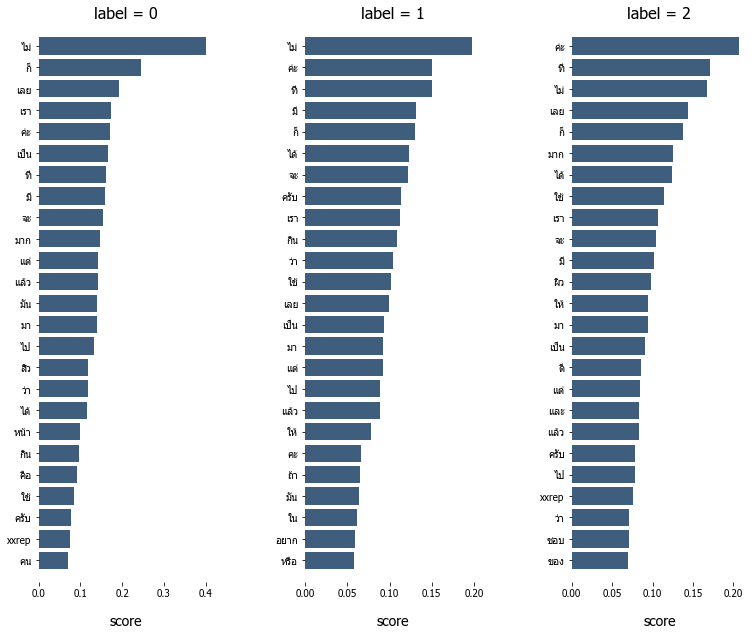

CPU times: total: 359 ms
Wall time: 365 ms


In [14]:
%time plot_top_feats(ts)

## TF-IDF

In [15]:
# TF-IDF with unigram and bigrams
tfidf1 = TfidfVectorizer(tokenizer=process_text, ngram_range=(1, 1), min_df=5)
tfidf2 = TfidfVectorizer(tokenizer=process_text, ngram_range=(2, 2), min_df=5)

# fit kt and transform to both datasets
tfidf1_fit_kt = tfidf1.fit(df_kt['text'].apply(str))
text_tfidf1_kt = tfidf1_fit_kt.transform(df_kt['text'].apply(str))
lex_tfidf1_kt = tfidf1_fit_kt.get_feature_names()
text_tfidf1_ws = tfidf1_fit_kt.transform(df_ws['texts'].apply(str))
lex_tfidf1_ws = tfidf1_fit_kt.get_feature_names()

tfidf2_fit_kt = tfidf2.fit(df_kt['text'].apply(str))
text_tfidf2_kt = tfidf2_fit_kt.transform(df_kt['text'].apply(str))
lex_tfidf2_kt = tfidf2_fit_kt.get_feature_names()
text_tfidf2_ws = tfidf2_fit_kt.transform(df_ws['texts'].apply(str))
lex_tfidf2_ws = tfidf2_fit_kt.get_feature_names()

print(text_tfidf1_kt.toarray().shape,  text_tfidf1_kt.toarray().shape)
print(text_tfidf2_kt.toarray().shape,  text_tfidf2_kt.toarray().shape)
print("\n")
print(text_tfidf1_ws.toarray().shape,  text_tfidf1_ws.toarray().shape)
print(text_tfidf2_ws.toarray().shape,  text_tfidf2_ws.toarray().shape)

print("\n")
print(len(lex_tfidf1_kt), len(lex_tfidf1_ws))
print(len(lex_tfidf2_kt), len(lex_tfidf2_ws))

C:\Users\Pree\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Pree\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(60081, 6459) (60081, 6459)
(60081, 17303) (60081, 17303)


(26737, 6459) (26737, 6459)
(26737, 17303) (26737, 17303)


6459 6459
17303 17303


## Word2vec

In [16]:
from collections import Counter, defaultdict

class TfidfEmbeddingVectorizer(object):
    def __init__(self, model):
        w2v = {w: vec for w, vec in zip(model.wv.index_to_key, model.wv.vectors)}
        self.word2vec = w2v
        self.word2weight = None
        self.dim = model.vector_size
    
    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [17]:
import gensim
from pythainlp import word_vector
from gensim.models import Word2Vec, KeyedVectors

# create word2vec for kt corpus
w2v_kt = Word2Vec(vector_size=300, min_count=1, window=4, workers=4)
w2v_kt.build_vocab(df_kt['processed'])
w2v_kt.train(df_kt['processed'], total_examples=w2v_kt.corpus_count, epochs=100)
w2v_kt.wv.most_similar("บะหมี่")

[('กึ่ง', 0.4947815537452698),
 ('สำเร็จรูป', 0.45383313298225403),
 ('ญวน', 0.41905829310417175),
 ('ปคน', 0.38823696970939636),
 ('ผลไม้กระป๋อง', 0.38072469830513),
 ('อุด้ง', 0.37622466683387756),
 ('ต้มยำ', 0.3734627366065979),
 ('หมูสับ', 0.3715658485889435),
 ('ไส้กรอก', 0.367780476808548),
 ('แซ่บ', 0.3539275527000427)]

In [18]:
w2v_tfidf_emb_kt = TfidfEmbeddingVectorizer(w2v_kt)
w2v_tifdf_fit_kt = w2v_tfidf_emb_kt.fit(df_kt['text'].apply(str))

# transfrom on both corpuses
text_w2v_tfidf_kt = w2v_tifdf_fit_kt.transform(df_kt['text'].apply(str))
text_w2v_tfidf_ws = w2v_tifdf_fit_kt.transform(df_ws['texts'].apply(str))

## POS Tagging


In [19]:
# Implementation of exisiting pos-tagging techniques.  
# TODO: 1. test performance of ech

# concate word and tag with underscore (มัน_ADV)
def word_tag(pos):
    tag_list = []
    for item in pos:
        tag = ['_'.join(map(str, tups)) for tups in item]
        tag_list.append(' '.join(tag))
    return tag_list

# use only tag
def tag(pos):
    tag_list = []
    for item in pos:
        tmp = [el[1] for el in item]
        tag = ' '.join(map(str, tmp))
        tag_list.append(tag)
    return tag_list

# create custome tag for emoticon word
def tag_emoj(pos):
    tag_list = []
    
    for i in range(len(pos)):
        pl = [list(el) for el in pos[i]]
        tag_list.append(pl)

    for item in tag_list:
        for i, tag in enumerate(item):
            for j, word in enumerate(tag):
                if "EMJ" in word:
                    item[i][1] = "EMOJI"
    return tag_list

# this approach convert nest-list to simply list of word follows by tag ['word', 'NOUN']
def flatten(text):
    res = list(sum(text, ()))
    return res

In [20]:
%%time
from pythainlp.tag import pos_tag_sents

pos = pos_tag_sents(df_kt['processed'].tolist(), corpus='orchid_ud')
pos = tag_emoj(pos)
df_kt['post_tag1'] = pd.DataFrame(tag(pos))
df_kt['post_tag2'] = pd.DataFrame(word_tag(pos))

pos = pos_tag_sents(df_ws['processed'].tolist(), corpus='orchid_ud')
pos = tag_emoj(pos)
df_ws['post_tag1'] = pd.DataFrame(tag(pos))
df_ws['post_tag2'] = pd.DataFrame(word_tag(pos))

print(df_ws[['processed', 'post_tag1']].iloc[1000:1010])
print("\n")
print(df_ws['post_tag2'].iloc[1000:1010])

                                              processed  \
1000           [ไก่, เค็ม, ไป, นะ, ครับ, ไม่, ชอบ, เลย]   
1001              [ไก่, เคเอฟซี, หร่อย, กว่า, แมค, จืด]   
1002              [ของ, น้อย, มาก, ชู, ชิ, อ่ะ, โฮมโปร]   
1003          [ขอ, ใบ, อนุ, ญาติ, เป็น, นัก, ปั่น, ลวด]   
1004                 [ขอร้อง, ละ, ตัวหนังสือ, ถี่, จัง]   
1005              [ขุด, ทางเท้า, ตอน, ห้า, ครึ่ง, อะนะ]   
1006             [ควย, วันนั้น, จะ, พา, ใป, แดก, ใม่ใป]   
1007               [คอม, เพล็ก, มัน, ไม่, มี, กระทะทอง]   
1008           [ค่า, ชุด, ก็, เกิน, ค่า, กิน, ละ, มั้ง]   
1009  [ค่า, ชุด, ไทย, แพง, กว่า, ส่วนลด, EMJpersever...   

                                    post_tag1  
1000    NOUN VERB AUX VERB NOUN PART VERB ADV  
1001            NOUN NOUN ADJ SCONJ NOUN NOUN  
1002          ADP ADV ADV NOUN NOUN NOUN NOUN  
1003  VERB VERB NOUN NOUN VERB NOUN NOUN NOUN  
1004                    NOUN ADP NOUN ADJ ADV  
1005               NOUN NOUN NOUN NUM NUM ADV  
1006         N

In [21]:
# create bow vectors
from sklearn.feature_extraction.text import CountVectorizer
bow1 = CountVectorizer(ngram_range=(1, 1))
#bow2 = CountVectorizer(ngram_range=(2, 2))

text_pos_bow1_fit_kt = bow1.fit(df_kt['post_tag1'])
text_pos_bow1_kt = text_pos_bow1_fit_kt.transform(df_kt['post_tag1'])
text_pos_bow1_ws = text_pos_bow1_fit_kt.transform(df_ws['post_tag1'])

# text_pos_bow2_fit_kt = bow2.fit(df_kt['post_tag1'])
# text_pos_bow2_kt = text_pos_bow2_fit_kt.transform(df_kt['post_tag2'])
# text_pos_bow2_ws = text_pos_bow2_fit_kt.transform(df_ws['post_tag2'])

print(text_pos_bow1_kt.toarray().shape,  text_pos_bow1_kt.toarray().shape)
print(text_pos_bow1_ws.toarray().shape,  text_pos_bow1_ws.toarray().shape)

# print(text_pos_bow2_kt.toarray().shape,  text_pos_bow2_kt.toarray().shape)
# print(text_pos_bow2_ws.toarray().shape,  text_pos_bow2_ws.toarray().shape)

(60081, 15) (60081, 15)
(26737, 15) (26737, 15)


In [22]:
# create tfidf vectors
# tfidf1 = TfidfVectorizer(ngram_range=(1, 1))
# tfidf2 = TfidfVectorizer(ngram_range=(2, 2))

# text_pos_tfidf1_fit_kt = tfidf1.fit(df_kt['post_tag1'])
# text_pos_tfidf1_kt = text_pos_tfidf1_fit_kt.transform(df_kt['post_tag1'])
# text_pos_tfidf1_ws = text_pos_tfidf1_fit_kt.transform(df_ws['post_tag1'])

# text_pos_tfidf2_fit_kt = bow2.fit(df_kt['post_tag1'])
# text_pos_tfidf2_kt = text_pos_bow2_fit_kt.transform(df_kt['post_tag2'])
# text_pos_tfidf2_ws = text_pos_bow2_fit_kt.transform(df_ws['post_tag2'])

# print(text_pos_bow1_kt.toarray().shape,  text_pos_bow2_kt.toarray().shape)
# print(text_pos_bow1_ws.toarray().shape,  text_pos_bow2_ws.toarray().shape)

# print(text_pos_bow2_kt.toarray().shape,  text_pos_bow2_kt.toarray().shape)
# print(text_pos_bow2_ws.toarray().shape,  text_pos_bow2_ws.toarray().shape)

## Dictionary-based

In [27]:
# load list of our custom positive and negative words
with open(data_path_dict + 'pos_words.txt', encoding='utf-8') as f:
    pos_words = [line.rstrip('\n') for line in f]

with open(data_path_dict + 'neg_words.txt', encoding='utf-8') as f:
    neg_words = [line.rstrip('\n') for line in f]
pos_words = list(set(pos_words))
neg_words = list(set(neg_words))

In [28]:
bow1 = CountVectorizer(tokenizer=process_text, ngram_range=(1, 1))
bow2 = CountVectorizer(tokenizer=process_text, ngram_range=(2, 2))

my_vocabs = pos_words + neg_words
print('dict size: ', len(my_vocabs))

text_dict_bow1_fit = bow1.fit(my_vocabs)
text_dict_bow1_kt = text_dict_bow1_fit.transform(df_kt['text'].apply(str))
text_dict_bow1_ws = text_dict_bow1_fit.transform(df_ws['texts'].apply(str))

text_dict_bow2_fit = bow2.fit(my_vocabs)
text_dict_bow2_kt = text_dict_bow2_fit.transform(df_kt['text'].apply(str))
text_dict_bow2_ws = text_dict_bow2_fit.transform(df_ws['texts'].apply(str))

print(text_dict_bow1_kt.toarray().shape,  text_dict_bow1_kt.toarray().shape)
print(text_dict_bow1_ws.toarray().shape,  text_dict_bow1_ws.toarray().shape)

print(text_dict_bow2_kt.toarray().shape,  text_dict_bow2_kt.toarray().shape)
print(text_dict_bow2_ws.toarray().shape,  text_dict_bow2_ws.toarray().shape)

dict size:  91


C:\Users\Pree\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(60081, 100) (60081, 100)
(26737, 100) (26737, 100)
(60081, 33) (60081, 33)
(26737, 33) (26737, 33)


In [29]:
tfidf1 = TfidfVectorizer(tokenizer=process_text, ngram_range=(1, 1))
tfidf2 = TfidfVectorizer(tokenizer=process_text, ngram_range=(2, 2))

text_dict_tfidf1_fit = tfidf1.fit(my_vocabs)
text_dict_tfidf1_kt = text_dict_tfidf1_fit.transform(df_kt['text'].apply(str))
text_dict_tfidf1_ws = text_dict_tfidf1_fit.transform(df_ws['texts'].apply(str))

text_dict_tfidf2_fit = tfidf2.fit(my_vocabs)
text_dict_tfidf2_kt = text_dict_tfidf2_fit.transform(df_kt['text'].apply(str))
text_dict_tfidf2_ws = text_dict_tfidf2_fit.transform(df_ws['texts'].apply(str))

print(text_dict_tfidf1_kt.toarray().shape,  text_dict_tfidf1_kt.toarray().shape)
print(text_dict_tfidf1_ws.toarray().shape,  text_dict_tfidf1_ws.toarray().shape)

print(text_dict_tfidf2_kt.toarray().shape,  text_dict_tfidf2_kt.toarray().shape)
print(text_dict_tfidf2_ws.toarray().shape,  text_dict_tfidf2_ws.toarray().shape)

(60081, 100) (60081, 100)
(26737, 100) (26737, 100)
(60081, 33) (60081, 33)
(26737, 33) (26737, 33)


## Save to disk

In [30]:
import joblib
from scipy import sparse # for converting w2v embbed vector to spare matrix and targets  

In [31]:
y_t_kt = y_kt.to_numpy().reshape(-1, 1)
y_t_ws = y_ws.to_numpy().reshape(-1, 1)

y_t_kt = sparse.csr_matrix(y_t_kt)
y_t_ws = sparse.csr_matrix(y_t_ws)

In [32]:
arr_bow1_kt = np.hstack((text_bow1_kt, y_t_kt))
arr_bow2_kt = np.hstack((text_bow2_kt, y_t_kt))
joblib.dump(arr_bow1_kt, data_processed_path+'text_bow1_kt.pkl')
joblib.dump(arr_bow2_kt, data_processed_path+'text_bow2_kt.pkl')

joblib.dump(lex_bow1_kt, data_lexicon_path+'lex_bow1_kt.pkl')
joblib.dump(lex_bow2_kt, data_lexicon_path+'lex_bow2_kt.pkl')

['c:\\Users\\Pree\\Thai_SA_journal\\data\\processed\\lexicon\\lex_bow2_kt.pkl']

In [33]:
arr_bow1_ws = np.hstack((text_bow1_ws, y_t_ws))
arr_bow2_ws = np.hstack((text_bow2_ws, y_t_ws))
joblib.dump(arr_bow1_ws, data_processed_path+'text_bow1_ws.pkl')
joblib.dump(arr_bow2_ws, data_processed_path+'text_bow2_ws.pkl')

joblib.dump(lex_bow1_ws, data_processed_path+'lex_bow1_ws.pkl')
joblib.dump(lex_bow2_ws, data_processed_path+'lex_bow2_ws.pkl')

['c:\\Users\\Pree\\Thai_SA_journal\\data\\processed\\lexicon\\lex_bow2_ws.pkl']

In [34]:
arr_tfidf1_kt = np.hstack((text_tfidf1_kt, y_t_kt))
arr_tfidf2_kt = np.hstack((text_tfidf2_kt, y_t_kt))
joblib.dump(arr_tfidf1_kt, data_processed_path+'text_tfidf1_kt.pkl')
joblib.dump(arr_tfidf2_kt, data_processed_path+'text_tfidf2_kt.pkl')

joblib.dump(lex_tfidf1_kt, data_processed_path+'lex_tfidf1_kt.pkl')
joblib.dump(lex_tfidf2_kt, data_processed_path+'lex_tfidf2_kt.pkl')

['c:\\Users\\Pree\\Thai_SA_journal\\data\\processed\\lexicon\\lex_tfidf2_kt.pkl']

In [35]:
arr_tfidf1_ws = np.hstack((text_tfidf1_ws, y_t_ws))
arr_tfidf2_ws = np.hstack((text_tfidf2_ws, y_t_ws))
joblib.dump(arr_tfidf1_ws, data_processed_path+'text_tfidf1_ws.pkl')
joblib.dump(arr_tfidf2_ws, data_processed_path+'text_tfidf2_ws.pkl')

joblib.dump(lex_tfidf1_ws, data_processed_path+'lex_tfidf1_ws.pkl')
joblib.dump(lex_tfidf2_ws, data_processed_path+'lex_tfidf2_ws.pkl')

['c:\\Users\\Pree\\Thai_SA_journal\\data\\processed\\lexicon\\lex_tfidf2_ws.pkl']

In [36]:
arr_w2v_tfidf_kt = np.hstack(( sparse.csr_matrix(text_w2v_tfidf_kt), y_t_kt))
arr_w2v_tfidf_ws = np.hstack(( sparse.csr_matrix(text_w2v_tfidf_ws), y_t_ws))
joblib.dump(arr_w2v_tfidf_kt, data_processed_path+'text_w2v_tfidf_kt.pkl')
joblib.dump(arr_w2v_tfidf_ws, data_processed_path+'text_w2v_tfidf_ws.pkl')

['c:\\Users\\Pree\\Thai_SA_journal\\models\\text_w2v_tfidf_ws.pkl']

In [37]:
arr_pos_bow1_kt = np.hstack((text_pos_bow1_kt, y_t_kt))
#arr_pos_bow2_kt = np.hstack((text_pos_bow2_kt, y_t_kt))
joblib.dump(arr_pos_bow1_kt, data_processed_path+'text_pos_bow1_kt.pkl')
#joblib.dump(arr_pos_bow2_kt, data_processed_path+'text_pos_bow2_kt.pkl')

['c:\\Users\\Pree\\Thai_SA_journal\\models\\text_pos_bow1_kt.pkl']

In [38]:
arr_pos_bow1_ws = np.hstack((text_pos_bow1_ws, y_t_ws))
#arr_pos_bow2_ws = np.hstack((text_pos_bow2_ws, y_t_ws))
joblib.dump(arr_pos_bow1_ws, data_processed_path+'text_pos_bow1_ws.pkl')
#joblib.dump(arr_pos_bow2_ws, data_processed_path+'text_pos_bow2_ws.pkl')

['c:\\Users\\Pree\\Thai_SA_journal\\models\\text_pos_bow1_ws.pkl']

In [39]:
# arr_pos_tfidf1_kt = np.hstack((text_pos_tfidf1_kt, y_t_kt))
# arr_pos_tfidf2_kt = np.hstack((text_pos_tfidf2_kt, y_t_kt))
# joblib.dump(arr_pos_tfidf1_kt, data_processed_path+'text_pos_tfidf1_kt.pkl')
# joblib.dump(arr_pos_tfidf2_kt, data_processed_path+'text_pos_tfidf2_kt.pkl')

In [40]:
# arr_pos_tfidf1_ws = np.hstack((text_pos_tfidf1_ws, y_t_ws))
# arr_pos_tfidf2_ws = np.hstack((text_pos_tfidf2_ws, y_t_ws))
# joblib.dump(arr_pos_tfidf1_ws, data_processed_path+'text_pos_tfidf1_ws.pkl')
# joblib.dump(arr_pos_tfidf2_ws, data_processed_path+'text_pos_tfidf2_ws.pkl')

In [41]:
arr_dict_bow1_kt = np.hstack((text_dict_bow1_kt, y_t_kt))
arr_dict_bow2_kt = np.hstack((text_dict_bow2_kt, y_t_kt))
joblib.dump(arr_dict_bow1_kt, data_processed_path+'text_dict_bow1_kt.pkl')
joblib.dump(arr_dict_bow2_kt, data_processed_path+'text_dict_bow2_kt.pkl')

['c:\\Users\\Pree\\Thai_SA_journal\\models\\text_dict_bow2_kt.pkl']

In [42]:
arr_dict_bow1_ws = np.hstack((text_dict_bow1_ws, y_t_ws))
arr_dict_bow2_ws = np.hstack((text_dict_bow2_ws, y_t_ws))
joblib.dump(arr_dict_bow1_ws, data_processed_path+'text_dict_bow1_ws.pkl')
joblib.dump(arr_dict_bow2_ws, data_processed_path+'text_dict_bow2_ws.pkl')

['c:\\Users\\Pree\\Thai_SA_journal\\models\\text_dict_bow2_ws.pkl']

In [43]:
arr_dict_tfidf1_kt = np.hstack((text_dict_tfidf1_kt, y_t_kt))
arr_dict_tfidf2_kt = np.hstack((text_dict_tfidf2_kt, y_t_kt))
joblib.dump(arr_dict_tfidf1_kt, data_processed_path+'text_dict_tfidf1_kt.pkl')
joblib.dump(arr_dict_tfidf2_kt, data_processed_path+'text_dict_tfidf2_kt.pkl')

['c:\\Users\\Pree\\Thai_SA_journal\\models\\text_dict_tfidf2_kt.pkl']

In [44]:
arr_dict_tfidf1_ws = np.hstack((text_dict_tfidf1_ws, y_t_ws))
arr_dict_tfidf2_ws = np.hstack((text_dict_tfidf2_ws, y_t_ws))
joblib.dump(arr_dict_tfidf1_ws, data_processed_path+'text_dict_tfidf1_ws.pkl')
joblib.dump(arr_dict_tfidf2_ws, data_processed_path+'text_dict_tfidf2_ws.pkl')

['c:\\Users\\Pree\\Thai_SA_journal\\models\\text_dict_tfidf2_ws.pkl']

## Demonstrate usage


In [ ]:
# load kt corpus extracted features array 
#arr_kt = np.load(model_path+'text_tfidf2_kt.joblib')
    
item = joblib.load(model_path+'text_bow1_kt.pkl')

In [ ]:
#arr_kt = np.concatenate((item[0].A, item[1].A), axis=1)
arr_bow1_kt = np.hstack((text_bow1_kt, y_t_kt))
#arr_kt = np.concatenate(text_bow1_kt, y_t_kt)
arr_kt = np.concatenate((arr_bow1_kt[0].A, arr_bow1_kt[1].A), axis=1)

## Train-test split

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
train_df, test_df = train_test_split(arr_kt, test_size=0.20, random_state=42)
train_df.shape, test_df.shape

## Train-valid split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df[:,:-1], train_df[:,-1], test_size=0.15, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

## Test the extracted features with Logistic Regression

In [ ]:
# quick test with out cv
#fit logistic regression models
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train, y_train)
model.score(X_valid, y_valid)
#y_pred = model.predict(X_valid)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
def build_model(model):
    scores = (cross_val_score(model, X_train, y_train, cv = 5).mean())
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    acc_sc = accuracy_score(y_valid, y_pred)
    pre_sc = precision_score(y_valid, y_pred, average='weighted')
    rec_sc = recall_score(y_valid, y_pred, average='weighted')
    f1_sc = f1_score(y_valid, y_pred, average='weighted')
    print('Accuracy :',acc_sc)
    print('Confusion Matrix :\n', confusion_matrix(y_valid, y_pred))
    print('Precision :', pre_sc)
    print('Recall :', rec_sc)
    print('F1-score :', f1_sc)
    print('Classification Report :\n', classification_report(y_valid, y_pred))
    print('Average accuracy of k-fold (5-fold) :', scores ,'\n')

In [ ]:
build_model(model)

In [ ]:
# predict on kt dataset
#arr_ws = np.load(model_path+'text_tfidf2_ws.npy')
item = joblib.load(model_path+'text_tfidf2_ws.pkl')
arr_ws = np.concatenate((item[0].A, item[1].A), axis=1)
arr_ws.shape

In [ ]:
train_df, test_df = train_test_split(arr_ws, test_size=0.20, random_state=42)
train_df.shape, test_df.shape

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df[:,:-1], train_df[:,-1], test_size=0.15, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

In [ ]:
build_model(model)